# SNN_0

This code is designed to demo the use of a Spiking Neural Network to propogate spikes between neurons. At this stage there is no learning involved, it's purely about propogating spikes between LIF neurons.

More biologically plausible neurons and learning will be introduced later.

### Set up the environment

In [1]:
import numpy as np
from mnist import MNIST   
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
duration = 50        # Length of each time period (ms)

### Utility functions

In [10]:
def plot_spikes(time, Vm, neuron_id):
    plt.plot(time,Vm)
    plt.title('Leaky Integrate and Fire @ {}'.format(neuron_id))
    plt.ylabel('Membrane potential (V)')
    plt.xlabel('Time (msec)')
    plt.ylim([0,2])
    plt.show()

### Create a basic neuron class

Use LIF neuron for now, this can be made more complex over time.

Based on http://neurdon.wpengine.com/2011/01/19/neural-modeling-with-python-part-1/

In [49]:
class Neuron():
    def __init__(self):
        # Simulation config (may not all be needed!!)
        self.T        = 50          # total time to sumulate (msec)
        self.dt       = 0.125       # simulation time step
        #self.time     = np.arange(0, T+dt, dt) # Time array
        self.t_rest   = 0           # initial refractory time
        
        #LIF Properties 
        #self.Vm       = np.zeros(len(time)) # potential (V) trace over time
        self.Vm       = 0                # Initial potential (mV)
        self.t        = 0                # Neuron time step
        self.Rm       = 1                # Resistance (kOhm)
        self.Cm       = 10               # Capacitance (uF)
        self.tau_m    = self.Rm * self.Cm # Time constant
        self.tau_ref  = 4                # refractory period (ms)
        self.Vth      = 0.75             # = 1  #spike threshold
        self.V_spike  = 0.5              # spike delta (V)
    
    def spike_generator(self, input, duration):
        time = np.arange(self.t, self.t+duration+self.dt, self.dt)
        Vm = np.zeros(len(time)) # potential (V) trace over time
        Vm[-1] = self.Vm   # Vm[0] doesn't work due to the equation below starting with [i-1] when i=0
        print ('Neuron.spike_generator.initial_state(input={}, duration={}, Vm={}, t={})'
               .format(input, duration, self.Vm, self.t))
        for i,t in enumerate(time):
            if t > self.t_rest:
                Vm[i] = Vm[i-1] + (-Vm[i-1] + input*self.Rm) / self.tau_m * self.dt
                if Vm[i] >= self.Vth:
                    Vm[i] += self.V_spike
                    self.t_rest = t + self.tau_ref
                    #print ('*** Neuron.spike_generator.spike=(self.t_rest={}, t={}, self.tau_ref={})'
                    #       .format(self.t_rest, t, self.tau_ref))

            # Save state
            self.Vm = Vm[i]
            self.t += self.dt
        print ('Neuron.spike_generator.exit_state(Vm={} at iteration i={}, time={})'.format(self.Vm, i, self.t))
        return time, Vm

In [50]:
neuron = Neuron()

Neuron.spike_generator.initial_state(input=0.9, duration=50, Vm=0, t=0)
Neuron.spike_generator.exit_state(Vm=0.4201585902373152 at iteration i=400, time=50.125)


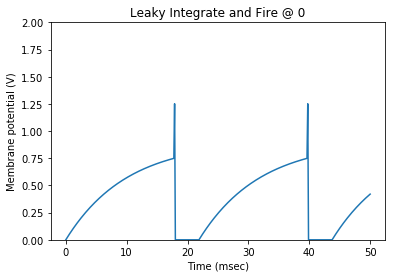

Neuron.spike_generator.initial_state(input=0.9, duration=50, Vm=0.4201585902373152, t=50.125)
Neuron.spike_generator.exit_state(Vm=0.6473670207872191 at iteration i=400, time=100.25)


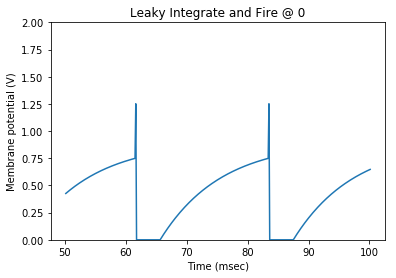

Neuron.spike_generator.initial_state(input=0.9, duration=50, Vm=0.6473670207872191, t=100.25)
Neuron.spike_generator.exit_state(Vm=0.6473670207872191 at iteration i=400, time=150.375)


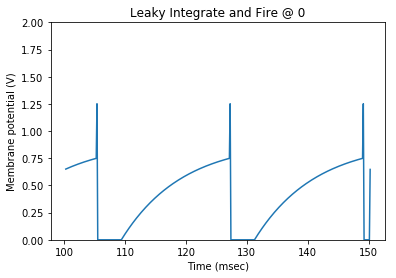

Neuron.spike_generator.initial_state(input=0.9, duration=50, Vm=0.6473670207872191, t=150.375)
Neuron.spike_generator.exit_state(Vm=0.2671782027787446 at iteration i=400, time=200.5)


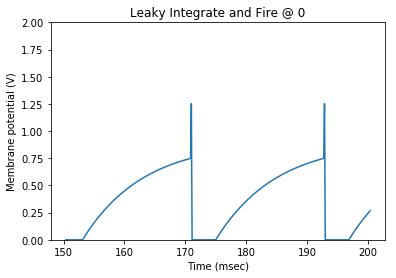

In [51]:
for time_step in range (4):
    time, Vm = neuron.spike_generator(.9, duration=50)
    plot_spikes(time, Vm, neuron_id = "0")